In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import efel

In [2]:
efel.get_feature_names()

['ADP_peak_amplitude',
 'ADP_peak_indices',
 'ADP_peak_values',
 'AHP1_depth_from_peak',
 'AHP2_depth_from_peak',
 'AHP_depth',
 'AHP_depth_abs',
 'AHP_depth_abs_slow',
 'AHP_depth_diff',
 'AHP_depth_from_peak',
 'AHP_depth_slow',
 'AHP_slow_time',
 'AHP_time_from_peak',
 'AP1_amp',
 'AP1_begin_voltage',
 'AP1_begin_width',
 'AP1_peak',
 'AP1_width',
 'AP2_AP1_begin_width_diff',
 'AP2_AP1_diff',
 'AP2_AP1_peak_diff',
 'AP2_amp',
 'AP2_begin_voltage',
 'AP2_begin_width',
 'AP2_peak',
 'AP2_width',
 'AP_amplitude',
 'AP_amplitude_change',
 'AP_amplitude_diff',
 'AP_amplitude_from_voltagebase',
 'AP_begin_indices',
 'AP_begin_time',
 'AP_begin_voltage',
 'AP_begin_width',
 'AP_duration',
 'AP_duration_change',
 'AP_duration_half_width',
 'AP_duration_half_width_change',
 'AP_end_indices',
 'AP_fall_indices',
 'AP_fall_rate',
 'AP_fall_rate_change',
 'AP_fall_time',
 'AP_height',
 'AP_peak_downstroke',
 'AP_peak_upstroke',
 'AP_phaseslope',
 'AP_rise_indices',
 'AP_rise_rate',
 'AP_rise_ra

In [13]:
efel.api.reset()
efel.api.set_setting("strict_stiminterval", False)
efel.api.set_setting("interp_step", 0.02)
efel.api.set_setting("Threshold", 0)
efel.api.set_setting("stimulus_current", 10)

In [8]:
print(efel.get_settings())

Threshold: 0.0
DerivativeThreshold: 10.0
DownDerivativeThreshold: -12.0
dependencyfile_path: /Users/han.hou/miniconda3/envs/patch-seq/lib/python3.10/site-packages/efel/DependencyV5.txt
spike_skipf: 0.1
max_spike_skip: 2
interp_step: 0.02
burst_factor: 1.5
strict_burst_factor: 2.0
voltage_base_start_perc: 0.9
voltage_base_end_perc: 1.0
current_base_start_perc: 0.9
current_base_end_perc: 1.0
rise_start_perc: 0.0
rise_end_perc: 1.0
initial_perc: 0.1
min_spike_height: 20.0
strict_stiminterval: False
initburst_freq_threshold: 50
initburst_sahp_start: 5
initburst_sahp_end: 100
DerivativeWindow: 3
voltage_base_mode: mean
current_base_mode: mean
precision_threshold: 1e-10
sahp_start: 5.0
ignore_first_ISI: True
impedance_max_freq: 50.0
AP_phaseslope_range: 2
inactivation_tc_end_skip: 10


In [60]:

from LCNE_patchseq_analysis.data_util.nwb import PatchSeqNWB

def efel_single_sweep(ephys_roi_id, sweep_number):
    raw = PatchSeqNWB(ephys_roi_id=ephys_roi_id)
    
    # Get trace and time for sweep 0 
    trace = raw.get_raw_trace(sweep_number)
    time = raw.dt_ms * np.arange(len(trace))
    stimulus = raw.get_stimulus(sweep_number)
    
    meta_this = raw.df_sweeps.query("sweep_number == @sweep_number").copy()
    meta_this.loc[:, "ephys_roi_id"] = ephys_roi_id
    stim_code = meta_this["stimulus_code"].values[0]
    stim_start = meta_this["stimulus_start_time"].values[0]
    stim_end = stim_start + meta_this["stimulus_duration"].values[0]

    # Use efel to get features
    traces = [
        {
            "T": time,
            "V": trace,
            "stim_start": [stim_start],
            "stim_end": [stim_end],
        }
    ]

    # Pass stimulus current to efel for input resistance calculation
    stimulus_current = meta_this["stimulus_amplitude"].values[0]

    # Must reset all settings otherwise stimulus_current can only be set once
    efel.api.reset()
    efel.api.set_setting("strict_stiminterval", False)
    efel.api.set_setting("interp_step", 0.02)
    efel.api.set_setting("Threshold", 0)
    efel.api.set_setting("stimulus_current", stimulus_current)
    
    df_features = pd.DataFrame(efel.get_feature_values(
        traces, efel.get_feature_names(), raise_warnings=False))
    
    return {
        "stim_code": stim_code,
        "time": time,
        "trace": trace,
        "meta": meta_this,
        "stimulus": stimulus,
        "stim_start": stim_start,
        "stim_end": stim_end}, df_features

In [17]:
from matplotlib.gridspec import GridSpec

def plot_sweep_raw(raw, df_features):
        time, trace, stimulus, stim_start, stim_end = raw["time"], raw["trace"], raw["stimulus"], raw["stim_start"], raw["stim_end"]
        
        time_interpolated = df_features["time"][0]
        
        # Plot the trace
        fig = plt.figure(figsize=(12, 6))
        gs = GridSpec(2, 1, height_ratios=[5, 1])
        ax = fig.add_subplot(gs[0, 0])
        ax_stimulus = fig.add_subplot(gs[1, 0], sharex=ax)

        ax.plot(time, trace, 'k-', lw=2)
        ax.axhline(df_features["voltage_base"][0], color="k", linestyle="--", label="voltage_base")
        
        if df_features["spike_count"][0][0] > 0:
                ax.plot(df_features["AP_begin_time"][0],
                        df_features["AP_begin_voltage"][0], "go",
                        label="AP_begin")
                ax.plot(df_features["peak_time"][0], df_features["peak_voltage"][0], "ro",
                        label="peak")
                ax.plot([time_interpolated[ind] for ind in df_features["min_AHP_indices"][0]],
                        df_features["min_AHP_values"][0], "ko",
                        label="min_AHP")

                # ["min_between_peaks_indices"]
                ax.plot([time_interpolated[ind] for ind in df_features["min_between_peaks_indices"][0]],
                        df_features["min_between_peaks_values"][0], "bo",
                        label="min_between_peaks")

                # Threshold
                threshold = efel.get_settings().Threshold
                ax.axhline(threshold, color="k", linestyle=":", label="threshold")

                # for i in range(df_features["spike_count"][0][0] - 1):
                #     ax.axhline(df_features["depolarized_base"][0][i], color="k", linestyle="--")

        # Plot sag, if "SubThresh" in stim_code
        if "SubThresh" in raw["stim_code"]:
            steady_state_voltage_stimend = df_features["steady_state_voltage_stimend"][0]
            ax.axhline(df_features["minimum_voltage"][0], color="gray", linestyle="--", label="minimum_voltage")
            ax.axhline(steady_state_voltage_stimend, color="deepskyblue", linestyle=":", label="steady_state_voltage_stimend")
            sag_amplitude = df_features["sag_amplitude"][0][0]
            ax.plot([stim_start, stim_start], 
                    [df_features["minimum_voltage"][0], df_features["minimum_voltage"][0] + sag_amplitude], 
                    color="deepskyblue", ls="-", label=f"sag_amplitude = {sag_amplitude:.2f}")
            voltage_deflection = df_features["voltage_deflection"][0][0]
            ax.plot([stim_start, stim_start], 
                    [steady_state_voltage_stimend, steady_state_voltage_stimend + (-voltage_deflection)], 
                     color="red", ls="-", label=f"voltage_deflection = {voltage_deflection:.2f}")

        # Add stimulus trace
        ax_stimulus.plot(time, stimulus, 'k-', lw=2)

        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('V (mV)')
        meta = raw["meta"]
        ax.set_title(f'{meta.ephys_roi_id.values[0]} sweep #{meta.sweep_number.values[0]}, {meta.stimulus_code.values[0]}')
        ax.set_xlim(stim_start - max(3, (stim_end - stim_start) * 0.2), stim_end + max(100, (stim_end - stim_start) * 0.4))
        ax.legend(loc="best", fontsize=12)
        ax.label_outer()
        ax.grid(True)

        sns.despine()
        return fig

def five_point_stencil_derivative(x, t):
    """
    Compute the derivative of a discrete signal x with corresponding time t
    using the five-point centered difference for interior points.
    
    For the boundaries, a simple two-point difference is used.
    
    Parameters:
        x : array-like
            Discrete signal values.
        t : array-like
            Corresponding time stamps (assumed uniformly spaced).
            
    Returns:
        dx : numpy array
            Approximated derivative of x with respect to t.
    """
    x = np.array(x)
    t = np.array(t)
    
    # Assume uniform spacing
    h = t[1] - t[0]
    
    # Initialize the derivative array
    dx = np.zeros_like(x)
    
    # Use the five-point centered difference for interior points
    # This is valid for indices 2 to len(x)-3
    for i in range(2, len(x) - 2):
        dx[i] = (-x[i+2] + 8*x[i+1] - 8*x[i-1] + x[i-2]) / (12 * h)
    
    # For the boundaries where the five-point formula cannot be applied, use lower-order differences:
    dx[0] = (x[1] - x[0]) / (t[1] - t[0])  # forward difference
    dx[1] = (x[2] - x[1]) / (t[2] - t[1])
    dx[-2] = (x[-2] - x[-3]) / (t[-2] - t[-3])
    dx[-1] = (x[-1] - x[-2]) / (t[-1] - t[-2])
    
    return dx

def plot_overlaid_spikes(raw, df_features):
    time, trace, stimulus, stim_start, stim_end = raw["time"], raw["trace"], raw["stimulus"], raw["stim_start"], raw["stim_end"]

    if df_features["spike_count"][0][0] == 0:
        return None
    
    # Plot individual spikes overlaid with some features

    sns.set_style("white")
    sns.set_context("talk")

    # peak_times = df_features["peak_time"][0]
    time_interpolated = df_features["time"][0]
    peak_times = [time_interpolated[ind] for ind in df_features["peak_indices"][0]]

    BEGIN_OFFSET = 2  # ms between begin_time to the eFEL AP_begin_time
    begin_times = [time_interpolated[ind] - BEGIN_OFFSET for ind in df_features["AP_begin_indices"][0]]
    end_times = begin_times[1:]  # From this begin to the start of tne next begin
    # end_times.append(stim_end)
    end_times.append(time_interpolated[df_features["min_between_peaks_indices"][0][-1]])

    n_spikes = len(peak_times)
    alphas = 0.8 * np.exp(-np.arange(n_spikes)/n_spikes)

    fig, axs = plt.subplots(1, 2, figsize=(13, 6))

    window = [-2, 6]  # Time window around a spike

    ax_v, ax_phase = axs

    # Plot the features for the first spike
    for i, (begin_time, end_time, peak_time) in reversed(list(enumerate(zip(begin_times, end_times, peak_times)))):
        # Get the trace around the spike
    #     start_time = peak_time + window[0]
    #     end_time = peak_time + window[1]
        idx = np.where((time >= begin_time) & (time <= end_time))[0]
        t = time[idx] - peak_time  # Center the time on the spike
        v = trace[idx]
        
        # dvdt = np.gradient(v, t)
        dvdt = five_point_stencil_derivative(v, t) # eFEL uses this

        if i > 0:
            # Only overlay the traces for following spikes with a lower opacity
            ax_v.plot(t, v, 'k', lw=0.5, alpha=alphas[i])
            
            # Plot the phase plot
            ax_phase.plot(v, dvdt, 'k', lw=0.5, alpha=alphas[i])
            continue

        # Plot the trace with some key features
        ax_v.plot(t, v, 'k', lw=3)
        ax_phase.plot(v, dvdt, 'k', lw=3)

        # Plot the peak
        ax_v.plot(0, df_features["peak_voltage"][0][i], "ro",
                label="peak", ms=10)

        # min_AHP
        ax_v.plot([time_interpolated[df_features["min_AHP_indices"][0][i]]] - peak_time,
                df_features["min_AHP_values"][0][i], "ko",
                label="min_AHP", ms=10)

        # AP_end
    #     ax_v.axvline(time_interpolated[df_features["AP_end_indices"][0][i]] - peak_time,
    #            color="b", label="AP_end")

        # AP_begin
        # Spike start is defined as where the first derivative of the voltage trace is higher than 10 V/s, for at least 5 points    
        t_begin = df_features["AP_begin_time"][0][i] - peak_time
        v_begin = df_features["AP_begin_voltage"][0][i]
        ax_v.plot(t_begin, v_begin, "go", label="AP_begin", ms=10)
        
        # AP_begin_width
        # https://efel.readthedocs.io/en/latest/eFeatures.html#ap-begin-width-ap1-begin-width-ap2-begin-width
        AP_begin_width = df_features["AP_begin_width"][0][i]        
        ax_v.plot([t_begin, t_begin + AP_begin_width],
                [v_begin, v_begin], "g-", label=f"AP_begin_width = {AP_begin_width:.2f}")

        # AP_width
        # https://efel.readthedocs.io/en/latest/eFeatures.html#ap-width
        threshold = efel.get_settings().Threshold
        threshold_time_idx = np.where(v >= threshold)[0][0]
        threshold_time = t[threshold_time_idx]
        AP_width = df_features["AP_width"][0][i]
        ax_v.plot(threshold_time, threshold, "ko", fillstyle="none", ms=10, label=f"Threshold $\equiv$ {threshold} mV")
        ax_v.plot([threshold_time, threshold_time + AP_width],
                [threshold, threshold], "k-", label=f"AP_width = {AP_width:.2f}")

        # AP_width_between_threshold
        # https://efel.readthedocs.io/en/latest/eFeatures.html#ap-width-between-threshold
        # Should be the same as AP_width for most cases

        # AP_duration_half_width
        # https://efel.readthedocs.io/en/latest/eFeatures.html#ap-duration-half-width
        half_rise_time = time_interpolated[df_features["AP_rise_indices"][0][i]] - peak_time
    #     half_fall_time = time_interpolated[df_features["AP_fall_indices"][0][i]] - peak_time
        half_voltage = (df_features["AP_begin_voltage"][0][i] + df_features["peak_voltage"][0][i]) / 2
        AP_duration_half_width = df_features["AP_duration_half_width"][0][i]
        ax_v.plot(half_rise_time, half_voltage, "mo", ms=10)
        ax_v.plot([half_rise_time, half_rise_time + AP_duration_half_width],
                [half_voltage, half_voltage], "m-", label=f"AP_duration_half_width = {AP_duration_half_width:.2f}")
        
        # Phase plot: phaseslope
        begin_ind = np.where(t >= t_begin)[0][0]
        ax_phase.plot(v[begin_ind], dvdt[begin_ind], 'go', ms=10, label="AP_begin")
        ax_phase.axhline(efel.get_settings().DerivativeThreshold, color="g", linestyle=":", label="Derivative threshold")
        
        # Phase plot: AP_phaseslope
        xx = np.linspace(v[begin_ind], v[begin_ind] + 10, 100)
        yy = dvdt[begin_ind] + (xx - v[begin_ind]) * df_features["AP_phaseslope"][0][i]
        ax_phase.plot(xx, yy, "g--", label=f"AP_phaseslope")
        
        # Phase plot: AP_peak_upstroke
        ax_phase.axhline(df_features["AP_peak_upstroke"][0][i], color="c", linestyle="--", label="AP_peak_upstroke")
        
        # Phase plot: AP_peak_downstroke
        ax_phase.axhline(df_features["AP_peak_downstroke"][0][i], color="darkblue", linestyle="--", label="AP_peak_downstroke")
        
    # For 1D array or single subplot
    ax_v.set_xlim(-BEGIN_OFFSET, 6)
    ax_v.set_xlabel('Time (ms)')
    ax_v.set_ylabel('V (mV)')
    ax_v.set_title(f'Overlaid spikes (n = {n_spikes})')
    ax_v.legend(loc="best", fontsize=12, title="1st spike features", title_fontsize=13)  # Outside the plot
    ax_v.grid(True)

    ax_phase.set_xlabel('Voltage (mV)')
    ax_phase.set_ylabel('dv/dt (mV/ms)')
    ax_phase.set_title('Phase Plots')
    ax_phase.legend(loc="best", fontsize=12, title="1st spike features", title_fontsize=13)  # Outside the plot
    ax_phase.grid(True)

    fig.tight_layout()
    sns.despine()
    
    return fig


def plot_sweep_summary(raw, df_features):
        plot_sweep_raw(raw, df_features)
        plot_overlaid_spikes(raw, df_features)

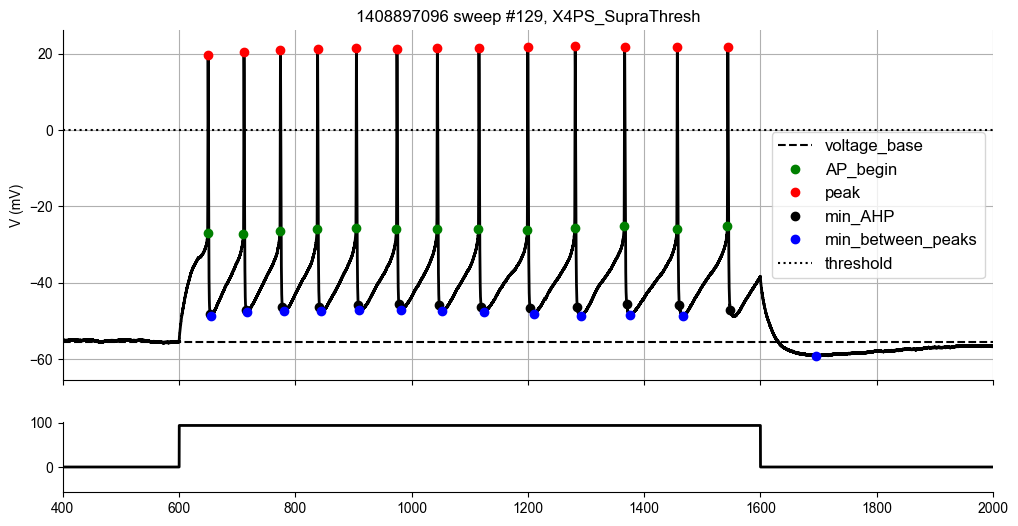

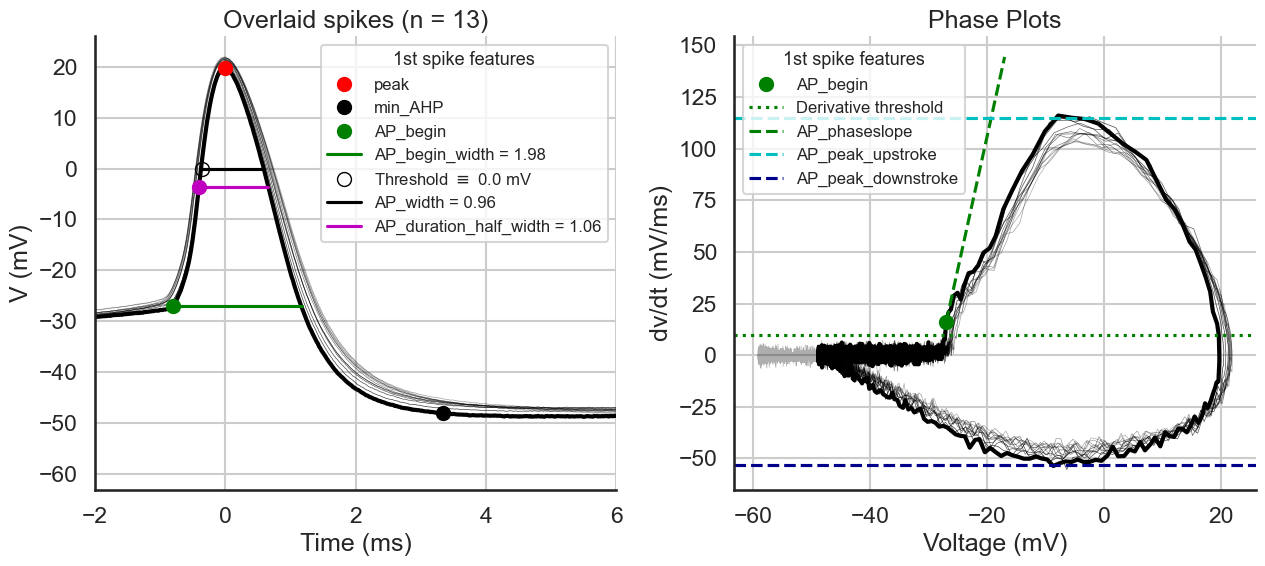

In [18]:
# Load an example NWB file
ephys_roi_id = "1408897096"
sweep_number = 129

raw, df_features = efel_single_sweep(ephys_roi_id, sweep_number)
_ = plot_sweep_summary(raw, df_features)

INFO:LCNE_patchseq_analysis.data_util.nwb:Loading NWB file /Users/han.hou/Scripts/LCNE-patchseq-analysis/src/LCNE_patchseq_analysis/../../data/LCNE-patchseq-ephys-raw/Ephys_Roi_Result_1212557784/Gad2-IRES-Cre;Ai14-643791.10.06.02.nwb
INFO:LCNE_patchseq_analysis.data_util.metadata:Loaded stimulus_summary from /Users/han.hou/Scripts/LCNE-patchseq-analysis/src/LCNE_patchseq_analysis/../../data/LCNE-patchseq-ephys-raw/Ephys_Roi_Result_1212557784/202209201201_EPHYS_NWB_STIMULUS_SUMMARY_V3_QUEUE_1212557784_output.json
INFO:LCNE_patchseq_analysis.data_util.metadata:Loaded qc from /Users/han.hou/Scripts/LCNE-patchseq-analysis/src/LCNE_patchseq_analysis/../../data/LCNE-patchseq-ephys-raw/Ephys_Roi_Result_1212557784/202209201205_EPHYS_QC_V3_QUEUE_1212557784_output.json
INFO:LCNE_patchseq_analysis.data_util.metadata:Loaded ephys_fx from /Users/han.hou/Scripts/LCNE-patchseq-analysis/src/LCNE_patchseq_analysis/../../data/LCNE-patchseq-ephys-raw/Ephys_Roi_Result_1212557784/202301171357_EPHYS_FEATURE

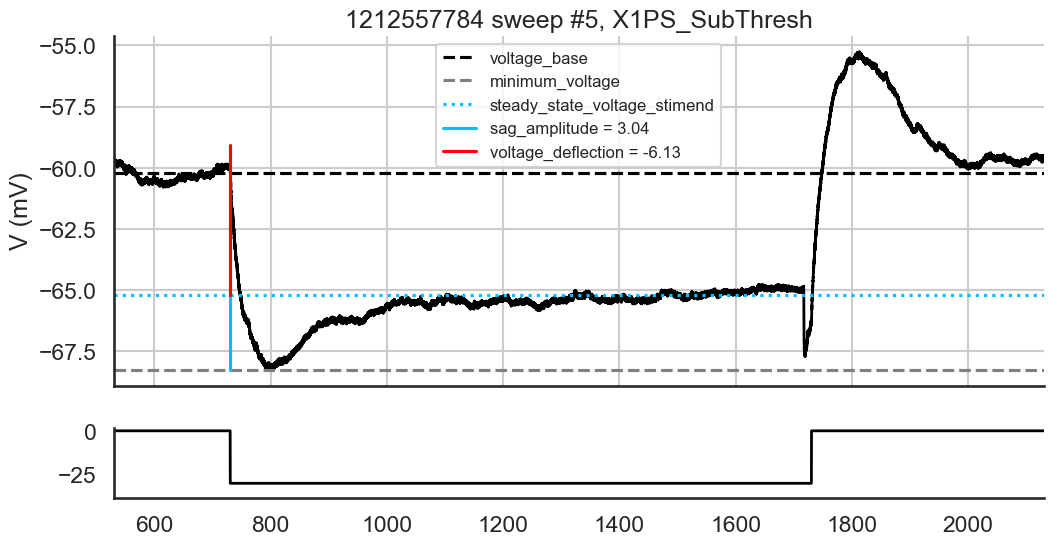

In [76]:
# Load an example NWB file
# ephys_roi_id = "1408897096"
# sweep_number = 129
# sweep_number = 93

# ephys_roi_id = "1408234639"
# sweep_number = 53

# ephys_roi_id = "1263776122"
# sweep_number = 33

# small spikes?!
# ephys_roi_id = "1408898832"
# sweep_number = 71

# sag
ephys_roi_id = "1212557784"
sweep_number = 5

raw, df_features = efel_single_sweep(ephys_roi_id, sweep_number)
_ = plot_sweep_summary(raw, df_features)

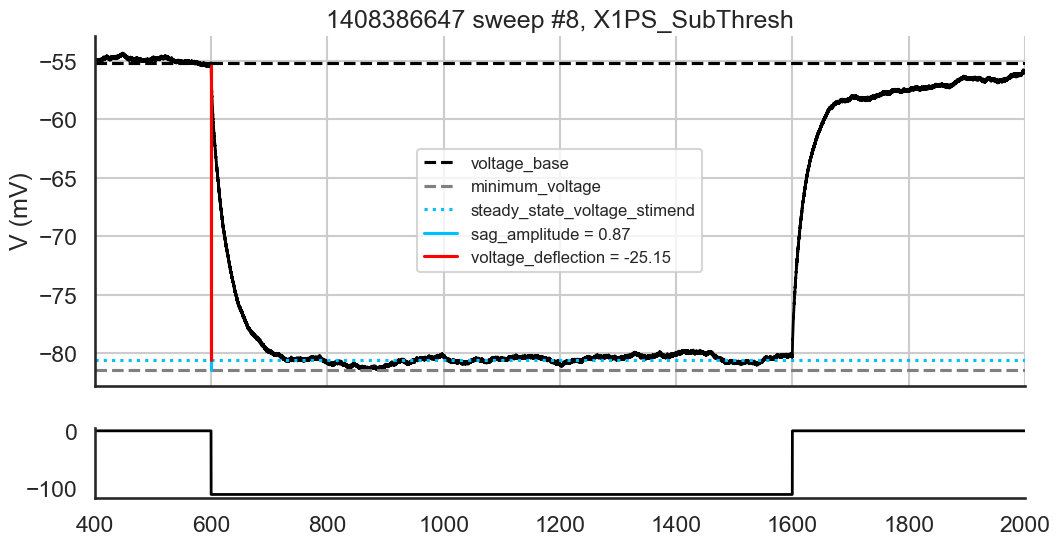

In [22]:
# Load an example NWB file
ephys_roi_id = "1408386647"
sweep_number = 8

raw, df_features = efel_single_sweep(ephys_roi_id, sweep_number)
_ = plot_sweep_summary(raw, df_features)

INFO:LCNE_patchseq_analysis.data_util.nwb:Loading NWB file /Users/han.hou/Scripts/LCNE-patchseq-analysis/src/LCNE_patchseq_analysis/../../data/LCNE-patchseq-ephys-raw/Ephys_Roi_Result_1408386647/Dbh-Cre-KI;Ai65-771648.07.01.02.nwb
INFO:LCNE_patchseq_analysis.data_util.metadata:Loaded stimulus_summary from /Users/han.hou/Scripts/LCNE-patchseq-analysis/src/LCNE_patchseq_analysis/../../data/LCNE-patchseq-ephys-raw/Ephys_Roi_Result_1408386647/202412041546_EPHYS_NWB_STIMULUS_SUMMARY_V3_QUEUE_1408386647_output.json
INFO:LCNE_patchseq_analysis.data_util.metadata:Loaded qc from /Users/han.hou/Scripts/LCNE-patchseq-analysis/src/LCNE_patchseq_analysis/../../data/LCNE-patchseq-ephys-raw/Ephys_Roi_Result_1408386647/202412041548_EPHYS_QC_V3_QUEUE_1408386647_output.json
INFO:LCNE_patchseq_analysis.data_util.metadata:Loaded ephys_fx from /Users/han.hou/Scripts/LCNE-patchseq-analysis/src/LCNE_patchseq_analysis/../../data/LCNE-patchseq-ephys-raw/Ephys_Roi_Result_1408386647/202412041551_EPHYS_FEATURE_EX

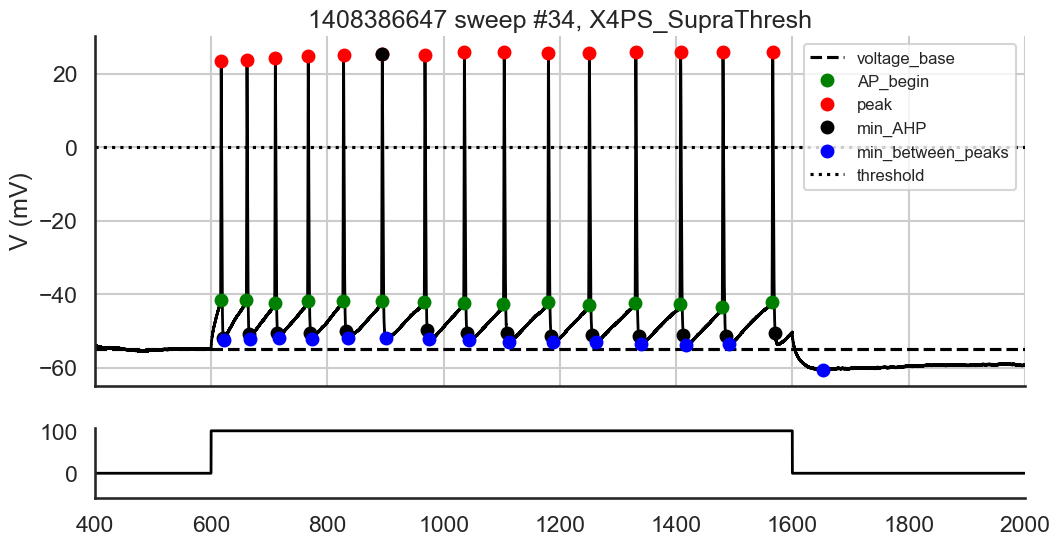

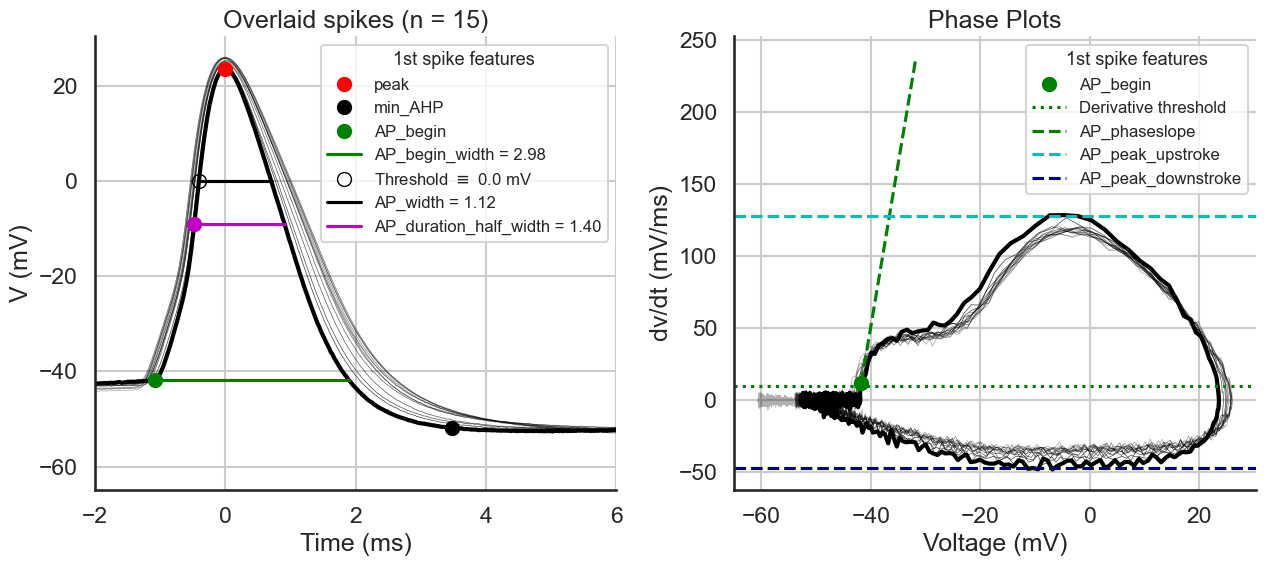

In [97]:
# Load an example NWB file
ephys_roi_id = "1408386647"
sweep_number = 34

raw, df_features = efel_single_sweep(ephys_roi_id, sweep_number)
_ = plot_sweep_summary(raw, df_features)

In [235]:
from LCNE_patchseq_analysis.efel.single_cell import pack_traces_for_efel

ephys_roi_id = "1212557784"

# Get raw data
raw = PatchSeqNWB(ephys_roi_id=ephys_roi_id)

# Package all valid sweeps for eFEL
traces, valid_sweep_numbers = pack_traces_for_efel(raw)

# Get all features
features = efel.get_feature_values(
    traces,
    efel.get_feature_names(),  # Get all features
    raise_warnings=False,
)

# Save features and add valid_sweep_numbers as the first column
df_features = pd.DataFrame(features, index=valid_sweep_numbers)
df_features.index.name = "sweep_number"



INFO:LCNE_patchseq_analysis.data_util.nwb:Loading NWB file /Users/han.hou/Scripts/LCNE-patchseq-analysis/src/LCNE_patchseq_analysis/../../data/LCNE-patchseq-ephys-raw/Ephys_Roi_Result_1212557784/Gad2-IRES-Cre;Ai14-643791.10.06.02.nwb
INFO:LCNE_patchseq_analysis.data_util.metadata:Loaded stimulus_summary from /Users/han.hou/Scripts/LCNE-patchseq-analysis/src/LCNE_patchseq_analysis/../../data/LCNE-patchseq-ephys-raw/Ephys_Roi_Result_1212557784/202209201201_EPHYS_NWB_STIMULUS_SUMMARY_V3_QUEUE_1212557784_output.json
INFO:LCNE_patchseq_analysis.data_util.metadata:Loaded qc from /Users/han.hou/Scripts/LCNE-patchseq-analysis/src/LCNE_patchseq_analysis/../../data/LCNE-patchseq-ephys-raw/Ephys_Roi_Result_1212557784/202209201205_EPHYS_QC_V3_QUEUE_1212557784_output.json
INFO:LCNE_patchseq_analysis.data_util.metadata:Loaded ephys_fx from /Users/han.hou/Scripts/LCNE-patchseq-analysis/src/LCNE_patchseq_analysis/../../data/LCNE-patchseq-ephys-raw/Ephys_Roi_Result_1212557784/202301171357_EPHYS_FEATURE

In [236]:
# Reformat df_features_per_sweep
# For each row (sweep),
#  if any element is len(1), make it a scalar
#  if any element is len(n) > 1, means these are features for multiple spikes,
#    then 1. extract the first element as a scalar, and save to first_spike_{col_name},
#         2. use a new df_features_per_spike, and save to index = {sweep_number, spike_number}
# If all elements are len(1), then just use df_features_per_sweep

# Create a new DataFrame for per-spike features
list_features_per_spike = []

# Create a new DataFrame for per-sweep features (with scalar values)
dict_features_per_sweep = {}

# Pop two columns "time" and "voltage" from df_features and save to "interpolated_time" and "interpolated_voltage"
interpolated_time = df_features["time"]
interpolated_voltage = df_features["voltage"]
df_features.drop(columns=["time", "voltage"], inplace=True)

# Process each column in the original DataFrame
for col in df_features.columns:
    lengths = df_features[col].map(lambda x: 0 if x is None else len(x))
    
    # Check if it's a scalar or array feature
    if max(lengths) == 1:
        # For single values, extract the scalar
        dict_features_per_sweep[col] = df_features[col].apply(lambda x: x[0] if x is not None and len(x) > 0 else None)
    else:
        # For multi-spike features
        # 1. Extract first spike value to per_sweep DataFrame
        dict_features_per_sweep[f"first_spike_{col}"] = df_features[col].apply(
            lambda x: x[0] if x is not None and len(x) > 0 else None
        )
        
        # 2. Expand to per-spike DataFrame
        for sweep_idx, sweep_values in df_features[col].items():
            if sweep_values is not None and len(sweep_values) > 0:
                for spike_idx, spike_value in enumerate(sweep_values):
                    list_features_per_spike.append(
                        {
                            "sweep_number": sweep_idx,
                            "spike_idx": spike_idx,
                            "feature": col,
                            "value": spike_value
                        }
                    )

# Pack dataframes
df_features_per_sweep = pd.DataFrame(dict_features_per_sweep)
df_features_per_spike = pd.DataFrame(list_features_per_spike).pivot(index=["sweep_number", "spike_idx"], columns="feature", values="value")



In [240]:
df_features

,ADP_peak_amplitude,ADP_peak_indices,ADP_peak_values,AHP1_depth_from_peak,AHP2_depth_from_peak,AHP_depth,AHP_depth_abs,AHP_depth_abs_slow,AHP_depth_diff,AHP_depth_from_peak,...,inv_ISI_values,inv_first_ISI,inv_second_ISI,inv_third_ISI,inv_fourth_ISI,inv_fifth_ISI,inv_last_ISI,activation_time_constant,deactivation_time_constant,inactivation_time_constant
sweep_number,,,,,,,,,,,,,,,,,,,,,
5,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,[1.1685670408914999],[7.178208887757946],[7.174072222436506]
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]","[89585, 89973, 90394, 90893, 91575, 92416, 935...","[-54.28125, -52.43749999789608, -51.3124999957...",[78.625],[76.7499999348212],"[5.779000136874899, 7.622750138978816, 8.74775...","[-54.28125, -52.43749999789608, -51.3124999957...","[-42.2187500042192, -41.40625000212168, -41.15...","[1.843750002103917, 1.1250000021280755, 0.5312...","[78.625, 76.7499999348212, 75.3124999619348, 7...",...,"[128.8659793815605, 118.2033096927789, 100.603...",[128.8659793815605],[118.2033096927789],[100.60362173047379],[73.52941176477276],[59.382422802904365],[17.921146953421317],[128.97950401975763],[5.122634043362268],[5.107236579361179]
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0624999913057...","[88527, 88925, 89355, 89846, 90437, 91294, 924...","[-54.56249999587459, -52.71874999377778, -51.5...",[78.37499994846505],[76.37499999377778],"[5.348968317841617, 7.192718319938429, 8.38021...","[-54.56249999587459, -52.71874999377778, -51.5...","[-43.09375000207976, -41.593750004184386, -40....","[1.8437500020968116, 1.1874999937777773, 0.781...","[78.37499994846505, 76.37499999377778, 75.3749...",...,"[124.37810945284944, 116.00928074256491, 102.4...",[124.37810945284944],[116.00928074256491],[102.4590163935358],[84.45945945953628],[58.3430571762491],[31.625553447214088],[209.1427495950604],[4.453517754429422],[4.441163582617327]


In [ ]:
df_features_per_spike

feature                 ADP_peak_amplitude  ADP_peak_indices  ADP_peak_values  \
sweep_number spike_idx                                                          
6            0                     0.00000           89585.0        -54.28125   
             1                     0.00000           89973.0        -52.43750   
             2                     0.00000           90394.0        -51.31250   
             3                     0.00000           90893.0        -50.78125   
             4                     0.00000           91575.0        -50.46875   
             5                     0.00000           92416.0        -51.18750   
             6                     0.00000           93520.0        -51.18750   
             7                     0.00000           95318.0        -51.84375   
             8                     6.00000           98379.0        -46.53125   
7            0                     0.00000           88527.0        -54.56250   
             1                     0.00000           88925.0        -52.71875   
             2                     0.00000           89355.0        -51.53125   
             3                     0.00000           89846.0        -50.75000   
             4                     0.00000           90437.0        -50.75000   
             5                     0.00000           91294.0        -50.71875   
             6                     0.06250           92424.0        -50.93750   
             7                     7.09375           94224.0        -44.43750   

feature                 AHP_depth  AHP_depth_abs  AHP_depth_abs_slow  \
sweep_number spike_idx                                                 
6            0           5.779000      -54.28125           -42.21875   
             1           7.622750      -52.43750           -41.40625   
             2           8.747750      -51.31250           -41.15625   
             3           9.279000      -50.78125           -41.62500   
             4           9.591500      -50.46875           -42.18750   
             5           8.872750      -51.18750           -43.71875   
             6           8.872750      -51.18750           -45.12500   
             7           8.216500      -51.84375                 NaN   
             8           7.529000      -52.53125                 NaN   
7            0           5.348968      -54.56250           -43.09375   
             1           7.192718      -52.71875           -41.59375   
             2           8.380218      -51.53125           -40.93750   
             3           9.161468      -50.75000           -41.78125   
             4           9.161468      -50.75000           -42.43750   
             5           9.192718      -50.71875           -43.84375   
             6           8.911468      -51.00000                 NaN   
             7           8.380218      -51.53125                 NaN   

feature                 AHP_depth_diff  AHP_depth_from_peak  AHP_depth_slow  \
sweep_number spike_idx                                                        
6            0            1.843750e+00             78.62500       17.841500   
             1            1.125000e+00             76.75000       18.654000   
             2            5.312500e-01             75.31250       18.904000   
             3            3.125000e-01             74.21875       18.435250   
             4           -7.187500e-01             73.46875       17.872750   
             5            6.323830e-11             74.59375       16.341500   
             6           -6.562500e-01             74.78125       14.935250   
             7           -6.875000e-01             75.78125             NaN   
             8                     NaN             76.93750             NaN   
7            0            1.843750e+00             78.37500       16.817718   
             1            1.187500e+00             76.37500       18.317718   
             2            7.812500e-01             75.37500     

In [239]:
df_features.spike_width2

sweep_number
5                                                 None
6    [0.3154752265065781, 0.3070918902385529, 0.323...
7    [0.3154921891537015, 0.3131507176335617, 0.318...
Name: spike_width2, dtype: object

In [241]:
efel.get_settings()

Settings(Threshold=0.0, DerivativeThreshold=10.0, DownDerivativeThreshold=-12.0, dependencyfile_path='/Users/han.hou/miniconda3/envs/patch-seq/lib/python3.10/site-packages/efel/DependencyV5.txt', spike_skipf=0.1, max_spike_skip=2, interp_step=0.02, burst_factor=1.5, strict_burst_factor=2.0, voltage_base_start_perc=0.9, voltage_base_end_perc=1.0, current_base_start_perc=0.9, current_base_end_perc=1.0, rise_start_perc=0.0, rise_end_perc=1.0, initial_perc=0.1, min_spike_height=20.0, strict_stiminterval=False, initburst_freq_threshold=50, initburst_sahp_start=5, initburst_sahp_end=100, DerivativeWindow=3, voltage_base_mode='mean', current_base_mode='mean', precision_threshold=1e-10, sahp_start=5.0, ignore_first_ISI=True, impedance_max_freq=50.0, AP_phaseslope_range=2, inactivation_tc_end_skip=10)

In [243]:
from LCNE_patchseq_analysis.efel.single_cell import load_dict_from_hdf5

loaded = load_dict_from_hdf5("data/efel_features/1418797120_efel_features.h5")

In [247]:
loaded["/interpolated_voltage"]

sweep_number
12    [-52.09375, -52.125, -52.09375, -52.125, -52.1...
13    [-52.53125, -52.5, -52.53125, -52.53125, -52.5...
18    [-52.8125, -52.78125, -52.8125, -52.78125, -52...
22    [-52.0, -52.0625, -52.0, -52.0, -52.03125, -52...
28    [-53.125, -53.125, -53.09375, -53.125, -53.093...
29    [-52.84375, -52.8125, -52.78125, -52.8125, -52...
36    [-52.78125, -52.71875, -52.75, -52.6875, -52.8...
37    [-53.09375, -53.15625, -53.09375, -53.09375, -...
38    [-54.28125, -54.1875, -54.21875, -54.25, -54.1...
40    [-51.78125, -51.84375, -51.8125, -51.84375, -5...
41    [-52.90625, -52.875, -52.875, -52.84375, -52.9...
42    [-51.96875, -51.96875, -52.0, -51.90625, -51.9...
48    [-52.8125, -52.75, -52.71875, -52.78125, -52.8...
49    [-52.65625, -52.5625, -52.5625, -52.625, -52.6...
50    [-52.75, -52.78125, -52.75, -52.8125, -52.7812...
55    [-52.75, -52.6875, -52.8125, -52.75, -52.6875,...
59    [-54.34375, -54.34375, -54.40625, -54.375, -54...
66    [-52.84375, -52.9375, -52.937